# Text Pre-Processing

---
In this notebook, we'll convert sentences from different sections of medical abstracts (e.g. background, methods, etc) into bag of words feature vectors. In a subsequent notebook, we'll then use these feature vectors to develop and test a predictive model.

Goals are as follows:

- Further improve your understanding of count-based text features
- Learn how to convert text data into features that can be used to develop a predictive model

We'll begin by importing the usual libraries in addition to `requests`, which will help us load the dataset from url. Later on, we'll also import a new one, the **natural language toolkit (nltk)**, which will help us preprocess our text data.

- numpy for efficient math operations
- pandas for data and dataframe manipulations
- matplotlib for visualization/plotting
- requests to load data from url
- **nltk for text pre-processing**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests

## Load the dataset

We'll be working with the "PubMed 200k RCT dataset" dataset developed by Franck Dernoncourt. This dataset contains sentences from different sections of Pubmed abstracts along with labels indicating which section they're from. The sections are:

- OBJECTIVE
- BACKGROUND
- METHODS
- RESULTS
- CONCLUSIONS

Over the next few exercises, our goal will be to develop a classifier that assigns sentences to the correct label. This is not a very useful classifier, but shows that natural language processing is effective even for text with complex terminology, including clinical notes. The training, validation, and test data are found at the following addresses:

In [2]:
train_url = 'https://github.com/Franck-Dernoncourt/pubmed-rct/raw/master/PubMed_20k_RCT/train.txt?raw=true'
val_url = 'https://github.com/Franck-Dernoncourt/pubmed-rct/raw/master/PubMed_20k_RCT/dev.txt?raw=true'
test_url = 'https://github.com/Franck-Dernoncourt/pubmed-rct/raw/master/PubMed_20k_RCT/test.txt?raw=true'

We'll begin by defining a function to read these data. Much like in previous exercises, **the details here are *not* important to our goals;** we just need the data. For now, we'll load only the training data (as `sentences` and `labels`), but in later exercises, we'll reuse these addresses and the function below to load the validation and test sets as well. To keep things manageable, we'll limit ourselves to the first 10k sentences and labels.

In [3]:
import requests

def read_pubmed_rct(url):

    labels = []
    sentences = []
    
    with requests.get(url) as r:
        for line in r.iter_lines():
            fields = line.decode('utf-8').strip().split('\t')
            if len(fields) == 2:
                labels.append(fields[0])
                sentences.append(fields[1])
                
    return sentences, labels

sentences, labels = read_pubmed_rct(train_url)

print('There are %i sentences in the training set' % len(sentences))

sentences, labels = sentences[:10000], labels[:10000]

print('But we will just use the first %i of them' % len(sentences))

There are 180040 sentences in the training set
But we will just use the first 10000 of them


## Inspect the dataset

It's always a good idea to take a look at a dataset when working with it for the first time. Let's count the number of each label in our training set:

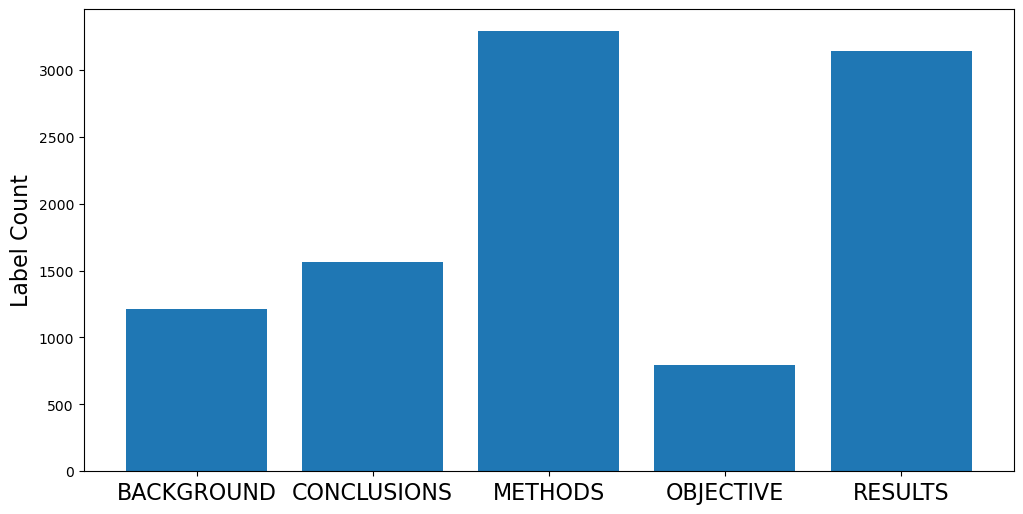

In [4]:
lbl, count = np.unique(labels, return_counts=True)
plt.figure(figsize=(12, 6))
plt.bar(np.arange(5), count)
plt.xticks(np.arange(5), lbl, fontsize=16)
plt.ylabel('Label Count', fontsize=16)
plt.show()

We can also take a look at the first few sentences:

In [5]:
sentences[:3]

['To investigate the efficacy of 6 weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at 12 weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .',
 'A total of 125 patients with primary knee OA were randomized 1:1 ; 63 received 7.5 mg/day of prednisolone and 62 received placebo for 6 weeks .',
 'Outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .']

## Import the Natural Language Toolkit (NLTK) for text processing

We can now import NLTK. We'll first make sure it's installed, since it's not part of the Anaconda base environment. We'll also import:
- `word_tokenize`, which splits a sentence into a list of *tokens* (e.g. words, numbers, punctuation)
- `stopwords`, a list of commonly used words that we can safely ignore when processing our text
- `PorterStemmer`, which will convert words into stems, as described in the lecture and shown in an example below

We'll also download lists of punctuation ('punkt') and stopwords ('stopwords'), then create `sw`, a set containing all the stopwords, and `ps`, an instance of `PorterStemmer` that we can apply to our words. **Before moving on, take a look at** `sw` **and try out** `word_tokenize` **on a few different sentences.**

In [6]:
!pip install nltk
import nltk

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

sw = set(stopwords.words('english'))
ps = PorterStemmer()

[nltk_data] Downloading package punkt to /Users/mme4/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/mme4/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /Users/mme4/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


## Other useful string methods

We'll also need to convert tokens to lowercase using the string method `.lower()`, and we can check whether a given string contains only letters with the string method `.isalpha()`. However, since we don't want to discard contractions, we can apply `.isalpha()` after first removing at most one apostrophe, as shown in the example below. Note that we can create strings that contain apostrophes (i.e. single quotes) by enclosing them in double quotes (rather than single). To summarize, we can:
- convert a string to lower case with `.lower()`
- check if a string contains only letters with `.isalpha()`
- check if string contains only letters and no more than one apostrophe with `.replace("'", "", 1).isalpha()`

In [7]:
# String methods in action

s = "SHOULDN'T"

s.lower(), s.isalpha(), s.replace("'", "", 1).isalpha()

("shouldn't", False, True)

Let's also take a quick look at stemming. If we stem the words 'coding', 'coded', and 'code', we end up with the same stem, 'code', each time:

In [8]:
ps.stem('coding'), ps.stem('coded'), ps.stem('code')

('code', 'code', 'code')

## Exercise 8.1: Process a single sentence

We now have all the tools we need to convert a sentence into a list of stemmed words that we can use to build our feature vectors. In the code block below, you should add lines to the `tokenize` function that will:
- remove stopwords
- convert words to lowercase
- step all words

Each of these steps will require a list comprehension (or a `for` loop). Optionally, try completing *all* steps with a single list comprehension.

In [ ]:
def tokenize(sentence):
    
    ### (done) SPLIT SENTENCE INTO WORDS USING word_tokenize ###
    words = word_tokenize(sentence)    
    
    ### (done) REMOVE WORDS THAT CONTAIN CHARACTERS OTHER THAN LETTERS AND AN APOSTROPHE ###
    words = [w for w in words if w.replace("'", '', 1).isalpha()]    
    
    ### REMOVE STOPWORDS ###
    
    
    ### CONVERT WORDS TO LOWERCASE ###
    
    
    ### STEM ALL WORDS ###
    
    
    return words

In [ ]:
tokenize(sentences[0])

## Exercise 8.2: Process all sentences

You can now use a single list comprehension to apply `tokenize` to *all* of the sentences, resulting in a list of 180,040 stemmed, tokenized sentences.

In [11]:
### ADD YOUR CODE BELOW ###



## Exercise 8.3: Create your vocabulary

We're now ready to create our vocabulary using the approach described in the [bag of words lecture](https://github.com/mengelhard/bsrt_ml4h/blob/master/lectures/al10.pdf). You'll need to complete the following steps:
- Put the stemmed tokens from *all* sentences together in a single list or array. This can be done with a list comprehension or `np.concatenate`.
- Count the number of occurrences of each distinct token. This can be done with `np.unique` (use `return_counts=True`) or `pd.Series().value_counts`.
- Remove those that occur fewer than 50 times. This can be done using boolean indexing: if we have the arrays `words` and `word_counts`, for example, we can write `vocabulary = words[word_counts >= 50]`. Later on, we'll explore how making this number larger or smaller affects model performance.

The resulting list (or array) is your vocabulary, which defines the features for our bag of words model.

In [12]:
### ADD YOUR CODE BELOW ###



## Define a function to create features

Finally, we can use (a) the vocabulary, and (b) our list of stemmed, tokenized sentences to create numeric features corresponding to each sentence. The block below defines a function `create_features` and shows how it can be applied to a sample list of tokenized sentences along with a sample vocabulary. **You do not need to make changes to this block, but please take a look at the code and verify that it is creating feature vectors using the approach described in our lecture.**

In [13]:
def create_features(tokenized_sentences, vocabulary):
    
    vocab_dict = {v:i for i, v in enumerate(vocabulary)}
    
    features = np.zeros((len(tokenized_sentences), len(vocabulary)))
    
    for i, tokenized_sentence in enumerate(tokenized_sentences):
        for word in tokenized_sentence:
            if word in vocabulary:
                features[i, vocab_dict[word]] += 1
            
    return features


sample_sentences = [
    ['a', 'smart', 'science', 'fiction', 'film'],
    ['unlike', 'anything', "we've", 'seen', 'in', 'science', 'fiction', 'before']
]

sample_vocab = ['smart', 'science', 'fiction', 'film', 'unlike', 'anything', 'seen', 'before']


create_features(sample_sentences, sample_vocab)

array([[1., 1., 1., 1., 0., 0., 0., 0.],
       [0., 1., 1., 0., 1., 1., 1., 1.]])

## Exercise 8.4: Create the feature vectors

*Your* list and vocabulary have been stemmed, so they'll look different than those in the example above. What's important is that the format of tokens in the vocabulary matches the format in the tokenized sentences, which should be the case if you've followed the steps outlined above.

In the block below, apply `create_features` to your tokenized sentence list and vocabulary to create `x_train`, which we'll use to train a predictive model in our next computational exercise.

## Steps to distribute your work as an html file:

If you're using Anaconda on your local machine:
- download your notebook as html (see `File > Download as > HTML (.html)`)

If you're using Google Colab:
- download your notebook as .ipynb (see `File > Download > Download .ipynb`)
- if you have nbconvert installed, convert it to .html and submit it in Talent LMS
- if not, you may need to place the .ipynb file in a .zip archive in order to distribute it (e.g. to upload or send via email)